# Course: Advanced Methods in Applied Statistics {-}
# Author: Kiril Klein (UCPH-ID: fjn197) {-}
I, Kiril Klein expressly vow to uphold my scientific, academic, and moral integrity by working individually on this exam and soliciting no direct external help or assistance.

In [944]:
import sys
sys.path.append('../')

In [945]:
import warnings
warnings.filterwarnings("ignore")

In [947]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import toolbox as tb
from toolbox import fits, vis
from toolbox import as_toolbox as ast
from toolbox.vis import Color_palette as Color_p
import urllib
from scipy import stats
from scipy import optimize
from scipy import interpolate
from toolbox.ExternalFunctions import NLLH
import importlib
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nestle

# Problem 1 {-}

In [949]:
url = "https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2021/data/Exam_2021_Prob1.txt"
D1 = pd.read_csv(url, sep=r" ", header = None, engine='python')

The figure below shows the data from the columns of interest.

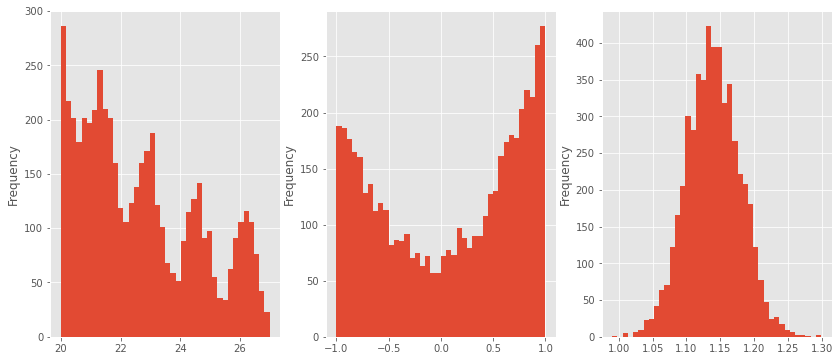

In [950]:
#plt.style.use('seaborn')
fig, ax = plt.subplots(1,3, figsize = (14,6))
ax = ax.flatten()
for i,j in enumerate([0,1,3]):
    D1.iloc[:,j].plot.hist(legend=False, bins = 40, ax = ax[i])

In [986]:
#choose and normalize functions
def f0(x, a,b,c ):
    xmax = 27
    xmin = 20
    Norm = -1/a*(np.cos(a*xmax)-np.cos(a*xmin)) + c/b*(np.exp(b*xmax)-np.exp(b*xmin)) 
    return (np.sin(a*x)+c*np.exp(b*x)+1)/Norm
def f1(x, a, b): return (1+ a*x + b*x**2)/(2+2/3*b)
#For the third column we have poisson, binomial, maybe logarithmic
def f3(x, a, b): return stats.norm.pdf(x, loc = a, scale = b)

def f_chi2(O, E): return np.sum((O-E)**2/E)

To  fit the data in the first column MCMC, nested sampling and maximum likelihood fits were performed, using the function:\begin{equation}
f(x) \sim  \sin{ax} + c\exp{bx}+1
\end{equation}
It was also tried to exclude c as a free parameter, which the fit was less sensitive too, and first try to scan the 2D likelihood landscape.
Trying to sample the parameter likelihood with nested sampling resulted in too long computation times.

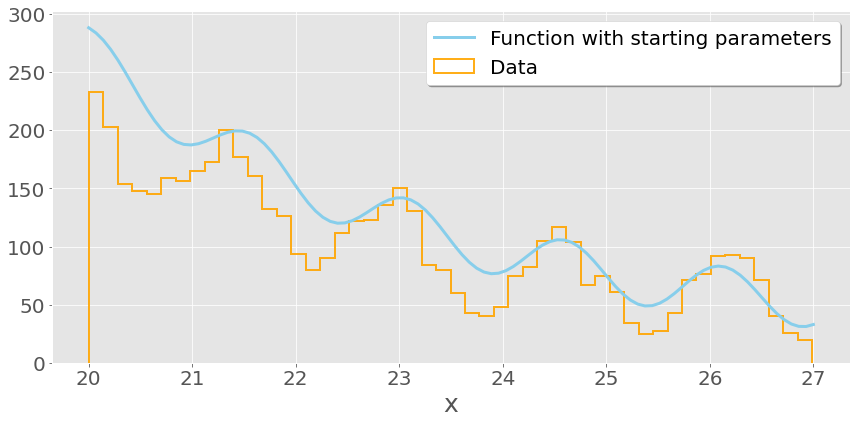

In [994]:
x0 = np.linspace(20,27,100)
fd0 = vis.nice_histogram(D1.iloc[:,0], 50, data_label_hist='Data')
p0 = [4.15,-.3,4500]
fig, ax = vis.nice_plot(x0, f0(x0, *p0)*len(D1)*fd0['binwidth'], 
                        figure = fd0['fig'], axis = fd0['ax'],
                       data_label= 'Function with starting parameters',
                       plot_legend=True)
fig

In [961]:
f_nllh = ast.NLLH(f0, D1.iloc[:,0])

def f_llikelihood(T):
    t1, t2 = T
    nllh = f_nllh(t1,t2)
    return -nllh
def prior_transform(x):
    return np.array([20 * x[0] - 10 , 20 * x[1]-10])#, 4000*x[2]+4000])

In [963]:
#for some reason nested sampling is too slow
#result = nestle.sample(
#    f_llikelihood, prior_transform, 2, method = 'multi', npoints = 100)
#logz = result.logz     # log evidence
#logzerr = result.logzerr  # numerical (sampling) error on logz
#samples = result.samples  # array of sample parameters
#weights = result.weights  # array of weights associated with each sample
#logl = result.logl
#print(result.summary())

In [992]:
def Neg_llh(x): return f_nllh(x[0],x[1])
ret_dict = optimize.minimize(Neg_llh, x0 = [4,-.32], 
                               bounds= [(-10,10), (-10,10)])

Trying to get the parameters with Monte Carlo also does not give the desired result.

In [995]:
#lets try MCMC
def f0p(x, a,b):
    c = 4500
    xmax = 27
    xmin = 20
    Norm = -1/a*(np.cos(a*xmax)-np.cos(a*xmin)) + c/b*(np.exp(b*xmax)-np.exp(b*xmin)) 
    return (np.sin(a*x)+c*np.exp(b*x)+1)/Norm
f_nllh = ast.NLLH(f0p, D1.iloc[:,0])
num_iter = 2000
def loglikelihood(a,b): return -f_nllh(a,b)
def prop(size): return stats.norm.rvs(loc = [0,0], scale = [.1,.1], size = size)
p0 = stats.norm.rvs(loc = [5,-.3], scale = [.5,.5], size = 2)
P_trace = np.empty((num_iter,2))
for i in range(num_iter):
        p_prop = p0+prop(size = 2)
        rand = np.random.uniform()
        if (np.exp(loglikelihood(*p_prop)) / np.exp(loglikelihood(*p0) ))>rand:
            p0 = p_prop
        else:
            pass
        P_trace[i,:] = p0

In [996]:
#fix c at 4000 and perform maximum likelihood scan
NLLH2d = ast.NLLH_scan(f0p, D1.iloc[:,0])
#grid, llh2d = NLLH2d(np.linspace(-10,10),np.linspace(-10,10))
#fig, ax = plt.subplots()
#ax.contourf(grid[0], grid[1], llh2d, 100)

In [999]:
#Lets perform likelihood fits for the functions that might be suitable
p0 = [4.15,-.3]
nbins = 50

dt0 = fits.hist_fit(
    f0p, D1.iloc[:,0], p0, fit_type = 'ullh', print_level = 0)
a0m, b0m = dt0['minuit_obj'].values[:]
fd0 = vis.nice_histogram(D1.iloc[:,0], 50)
fig, ax = vis.nice_plot(
    x0, f0p(x0, a0m, b0m)*len(D1)*fd0['binwidth'], 
    figure = fd0['fig'], axis = fd0['ax'])
#Both seem to fit reasonably well
LLH0 = dt0['minuit_obj'].fval
#ax.text(20, 10, f"NLLH =  {LLH0:2.1f}", color = Color_p(2)[0],fontsize = 25)
#fig

For columns 2 and 4, a maximum likelihood fit was performed to estimate best-fit parameters. The data was then binned using 50 bins from the minimal to the maximal value of the range. Binned data was used to compute a $\chi^2$ value and to detemine the correpsonding p-value. A function would be rejected if the p-value is below 0.05.
The fit to the data in column1 can be seen below. The large p-value indicates that the data was generated from this pdf.

In [1000]:
x1 = np.linspace(-1,1,100)
fd1 = vis.nice_histogram(D1.iloc[:,1], 50)
p1 = [1,1]
fig, ax = vis.nice_plot(x1, f1(x1, *p1)*len(D1)*fd1['binwidth'], figure = fd1['fig'], axis = fd1['ax'])

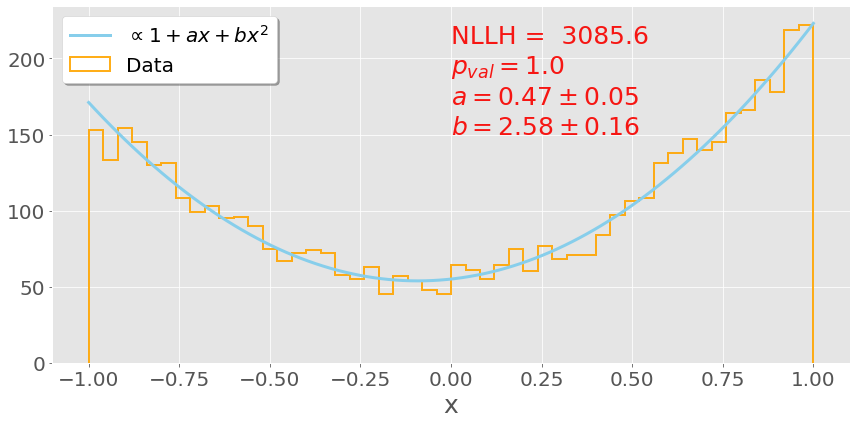

In [1021]:
#Lets perform likelihood fits for the functions that might be suitable
nbins = 50
dt1 = fits.hist_fit(
    f1, D1.iloc[:,1], p1, fit_type = 'ullh',
    observed = True, print_level = 0)
a1m, b1m = dt1['minuit_obj'].values[:]
sa1m, sb1m = dt1['minuit_obj'].errors[:]
fd1 = vis.nice_histogram(D1.iloc[:,1], 50, data_label_hist='Data')
p00 = [4.2,-.11,40]
fig, ax = vis.nice_plot(
    x1, f1(x1, a1m, b1m)*len(D1)*fd1['binwidth'],  plot_legend=True, label_fs=25,
    figure = fd1['fig'], axis = fd1['ax'], data_label = r"$\propto 1+ax+bx^2$")
#Both seem to fit reasonably well
LLH1 = dt1['minuit_obj'].fval
ax.text(0, 210, f"NLLH =  {LLH1:2.1f}", color = Color_p(2)[0],fontsize = 25)
ax.text(0, 170, r"$a = 0.47\pm0.05$", color = Color_p(2)[0],fontsize = 25)
ax.text(0, 150, r"$b = 2.58\pm0.16$", color = Color_p(2)[0],fontsize = 25)
#compute chi2 and pvalue using 50 bins
chi21 = f_chi2(fd1['y'], f1(fd1['x'],a1m, b1m)*len(D1)*fd1['binwidth'])
pval1 = stats.chi2.sf(chi21, len(D1)-2)
ax.text(0, 190, r"$p_{val} = 1.0$", color = Color_p(2)[0],fontsize = 25)
fig

The fit of data in column 4 also results in a high p-value, which justifies using this function for the fit.

In [1008]:
x3 = np.linspace(0,2.5,100)
fd3 = vis.nice_histogram(D1.iloc[:,3], 50)
p3 = [1.12,.04]
fig, ax = vis.nice_plot(x3, f3(x3, *p3)*len(D1)*fd3['binwidth'], figure = fd3['fig'], axis = fd3['ax'])
#fig

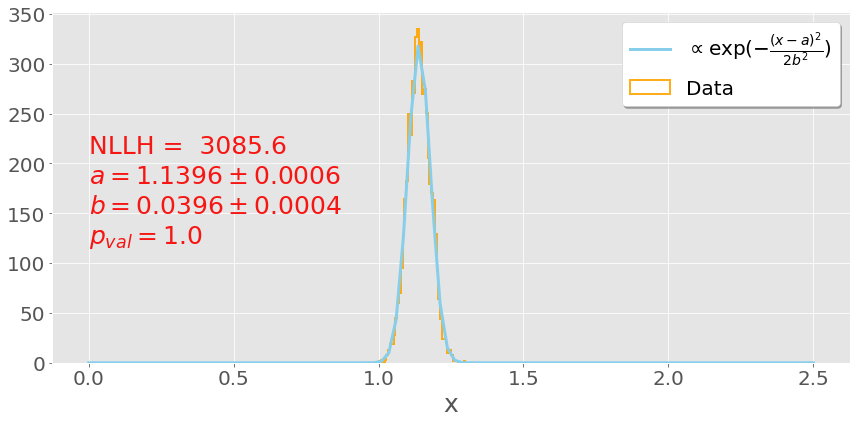

In [1024]:
#Lets perform likelihood fits for the functions that might be suitable
nbins = 50
dt3 = fits.hist_fit(
    f3, D1.iloc[:,3], p3, fit_type = 'ullh',
    observed = True, print_level = 0)
a3m, b3m = dt3['minuit_obj'].values[:]
sa3m, sb3m = dt3['minuit_obj'].errors[:]
fd3 = vis.nice_histogram(D1.iloc[:,3], 50, data_label_hist='Data',label_fs=25)
fig, ax = vis.nice_plot(
    x3, f3(x3, a3m, b3m)*len(D1)*fd3['binwidth'],  plot_legend=True,
    figure = fd3['fig'], axis = fd3['ax'], data_label = r"$\propto \exp{( -\frac{(x-a)^2}{2b^2})  }$")
#Both seem to fit reasonably well
LLH3 = dt3['minuit_obj'].fval
ax.text(0, 210, f"NLLH =  {LLH1:2.1f}", color = Color_p(2)[0],fontsize = 25)
ax.text(0, 180, r"$a = 1.1396\pm0.0006$", color = Color_p(2)[0],fontsize = 25)
ax.text(0, 150, r"$b = 0.0396\pm0.0004$", color = Color_p(2)[0],fontsize = 25)
chi3 = f_chi2(fd3['y'], f3(fd3['x'],a3m, b3m)*len(D1)*fd3['binwidth'])
pval3 = stats.chi2.sf(chi3, len(D1)-2)
ax.text(0, 120, r"$p_{val} = 1.0$", color = Color_p(2)[0],fontsize = 25)
fig

# Problem 2 {-} 

## Problem 2a {-}

Running 10000 pseudo-experiments in producing isotropic points on a unit sphere will be used to determine a test statistic for the KS-value. This will then be used to determine whether the data follows uniform distribution in $\varphi$ and $\cos{(\theta)}$. 

In [1025]:
url = "https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2021/data/Exam_2021_Problem2.txt"
D2 = np.loadtxt(url , skiprows = 2)
d_phi = D2[:,0]#azimuth angle from 0 to 2*pi
d_theta = D2[:,1]#zenith angle from 0 to pi

This figure shows a hammer-projection of the data.

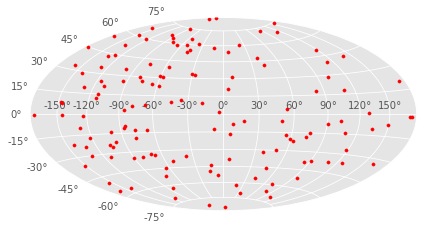

In [1026]:
plt.figure(figsize = (6,6))
plt.subplot(projection="hammer")
plt.scatter(d_phi-np.pi, d_theta-np.pi/2,  s=10, c='r', zorder=10)
plt.grid(True)
plt.tight_layout()
#Is this uniform? 

Below, we can see the cumulative autocorrelation for the data.

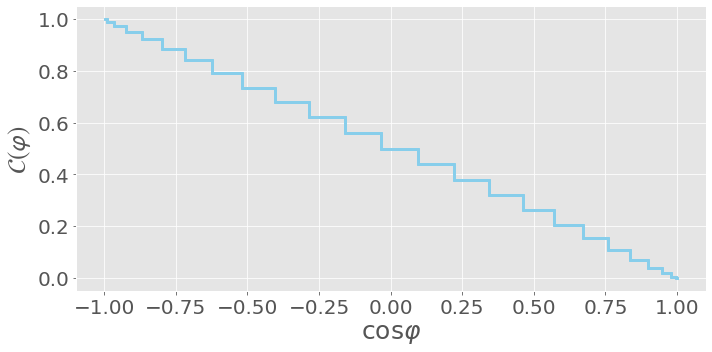

In [1027]:
#Autocorrelation for data
Npoints = len(D2)
nphi = 50
d_3d = ast.create_points3d(d_phi, d_theta)
x_phi = np.linspace(0, 2*np.pi,nphi)
iso = ast.f_isotropic(x_phi)#isotropic for large number of events
CAR_data = ast.cumulative_autocorrelation(d_3d, x_phi)
fig, ax = vis.nice_plot(
    np.cos(x_phi), CAR_data, drawstyle = 'steps-mid',
    xlabel = r"$\cos{\varphi}$", ylabel = r"$\mathcal{C(\varphi)}$")

In [1028]:
import importlib
_=importlib.reload(ast)

In [1029]:
#Produce pseudo experiments
Nexp = int(500)
#accelerate with numba
#@jit(forceobj = True)
def simulate_KS(Nexp):
    KS_iso = np.empty(Nexp)
    for i in range(Nexp):
        X_iso = ast.sample_spherical_uniform(Npoints)
        KS_iso[i] = np.max(np.abs(ast.cumulative_autocorrelation(X_iso, x_phi)-iso))
    return KS_iso

In [1030]:
KS_iso = simulate_KS(Nexp)
KS_data = np.max(np.abs(CAR_data-iso))

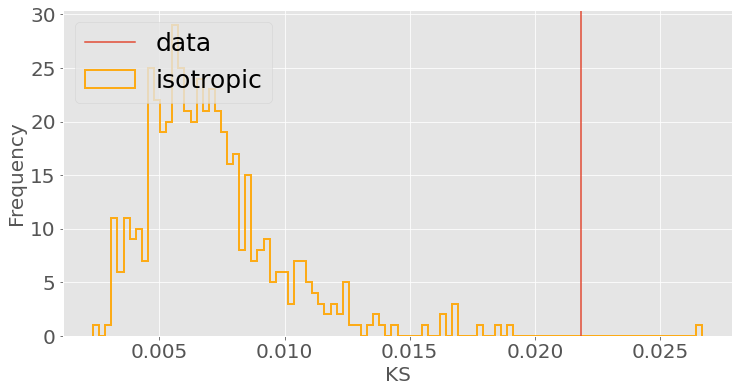

In [1031]:
fd = vis.nice_histogram(
    KS_iso, 100, data_label_hist='isotropic', xlabel = 'KS',
    plot_legend=True)
fd['ax'].axvline(KS_data, label = 'data')
fd['ax'].legend(fontsize = 25)
fd['fig']

In [1032]:
#compute integral
KSx, KSy = fd['x'], fd['y']
data_mask = KSx>KS_data
integral_abs = np.sum(KSy[data_mask])
integral_iso = integral_abs/np.sum(KSy)
print(integral_iso)

0.002


The integral (p-value) is 0.0044, we can therefore reject the isotropic hypothesis for the data.

## Problem 2b {-} 

In [1033]:
Nexp = 10
Nuniform = int(Npoints*0.8)
Nha = int(Npoints*0.2)
aphi = np.random.uniform(size = Nha)*(0.725-0.225)*np.pi + 0.225*np.pi
atheta = np.random.uniform(size = Nha)*(1-0.3)*np.pi + 0.3*np.pi
#@jit(forceobj = True)
def simulate_KS_HA(Nexp):
    KS_HA = np.empty(Nexp)
    iso = ast.f_isotropic(x_phi)
    for i in range(Nexp):
        X_HA = ast.create_points3d(aphi, atheta)
        X_iso = ast.sample_spherical_uniform(Nuniform)
        X_HA = np.concatenate((X_HA, X_iso), axis = 1)
        KS_HA[i] = np.max(np.abs(ast.cumulative_autocorrelation(X_HA, x_phi)-iso))
    return KS_HA

In [1036]:
KS_HA = simulate_KS_HA(100)

This figure shows the KS value distribution for hypothesis A. The p-value is 0.33 the hypothesis should therefore not be rejeceted.

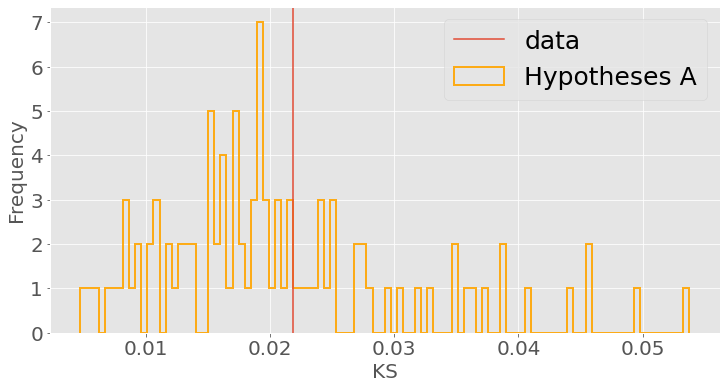

In [1037]:
fdA = vis.nice_histogram(
    KS_HA, 100, data_label_hist='Hypotheses A', xlabel = 'KS',
    plot_legend=True)
fdA['ax'].axvline(KS_data, label = 'data')
fdA['ax'].legend(fontsize = 25)
fdA['fig']

In [1042]:
#compute integral
KSx, KSy = fdA['x'], fdA['y']
data_mask = KSx>KS_data
integral_abs = np.sum(KSy[data_mask])
integral_iso = integral_abs/np.sum(KSy)
#rint(integral_iso)

For hypothesis B one gets a p-value of 0.11 thus it also should not be rejected.

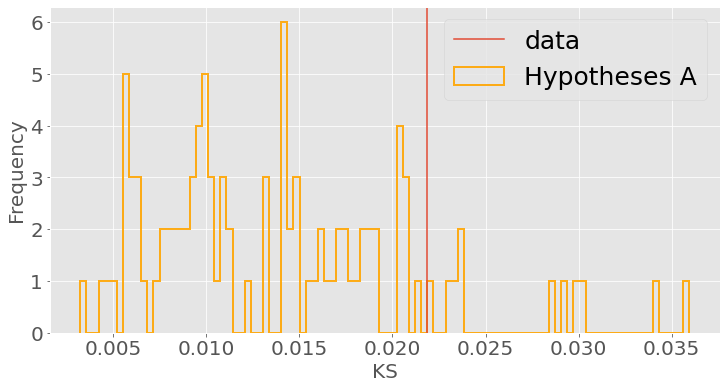

In [1040]:
Nexp = 10
NuniformB = int(Npoints*0.85)
NHB = int(Npoints*0.15)
bphi = np.random.uniform(size = NHB)*np.pi 
btheta = np.random.uniform(size = NHB)*0.5*np.pi + 0.5*np.pi
def simulate_KS_HB(Nexp):
    KS_HB = np.empty(Nexp)
    iso = ast.f_isotropic(x_phi)
    for i in range(Nexp):
        X_HB = ast.create_points3d(bphi, btheta)
        X_iso = ast.sample_spherical_uniform(Nuniform)
        X_HB = np.concatenate((X_HB, X_iso), axis = 1)
        KS_HB[i] = np.max(np.abs(ast.cumulative_autocorrelation(X_HB, x_phi)-iso))
    return KS_HB
KS_HB = simulate_KS_HB(100)
fdB = vis.nice_histogram(
    KS_HB, 100, data_label_hist='Hypotheses A', xlabel = 'KS',
    plot_legend=True)
fdB['ax'].axvline(KS_data, label = 'data')
fdB['ax'].legend(fontsize = 25)
fdB['fig']

In [1043]:
#compute integral
KSx, KSy = fdB['x'], fdB['y']
data_mask = KSx>KS_data
integral_abs = np.sum(KSy[data_mask])
integral_iso = integral_abs/np.sum(KSy)
#print(integral_iso)

# Problem 3 {-} 

## Problem 3a {-} 

We start with one crabe. If a step would reach the boundary, we divide the step size by two and try again until the crab can make a step. After a step is done, a new direction is chosen.

In [1044]:
Start = np.array([3.6, -2])
Radius = 5.
Ndays = 200
step_size = 0.2
Positions = np.empty((Ndays, 2))
np.random.seed(1)
for i in range(Ndays):
    Step = ast.sample_spherical_uniform(1,2)*step_size
    Next = Start + Step
    n = 2.
    while np.linalg.norm(Next)>Radius:
        if n<=2**8:
            Next = Start + Step/n
        else:
            Step = ast.sample_spherical_uniform(1,2)*step_size
            n = 2.
            Next = Start + Step
            #a new direction is proposed if the crab is too close to the edge
            #0.2/2**8 which is approx .7 m and steps towards the edge
        n *= 2.
    Start = Next
    Positions[i] = Next

Scatter plot for positions of one crab during 200 days.

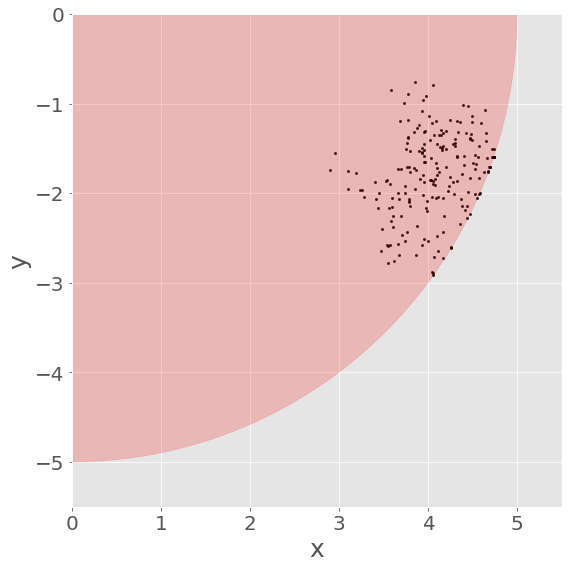

In [342]:
fig, ax = plt.subplots(figsize = (8,8)) # note we must use plt.subplots, not plt.subplot
fig, ax = vis.nice_plot(
    Positions[:,0], Positions[:,1], scatter=True,scr_markerstyle='.',
    figure = fig, axis = ax, scr_markersize=20, show_plot=False,color = 'k',
    y_range = (-5.5,0), x_show_range=(0,5.5), ylabel='y', alpha = 1)
circle1 = plt.Circle((0, 0), Radius, color='r', alpha = .2)
ax.add_patch(circle1)
fig

## Problem 3b {-} 

In [1045]:
Start = np.array([3.6, -2])
Radius = 5.
step_size = 0.2
Ndays = 200
N_exp = 200
Distance_traveled = np.ones(N_exp)*Ndays*step_size
np.random.seed(2)
for nexp in range(N_exp):
    Start = np.array([3.6, -2])
    for i in range(Ndays):
        Step = ast.sample_spherical_uniform(1,2)*step_size
        Next = Start + Step
        n = 2.
        #print(np.linalg.norm(Next))
        while np.linalg.norm(Next)>Radius:
            if n<=2**8:
                Next = Start + Step/n
            else:
                Distance_traveled[nexp] = i*step_size
                break
            n *= 2.
        Start = Next

We can see that most crabs travel for 200 days without reaching the edge (last bin).

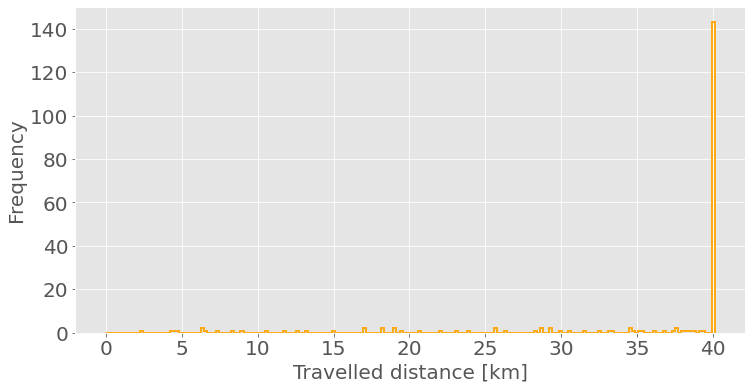

In [1046]:
bins = np.linspace(0, 40.1, int(40/0.2))
fd = vis.nice_histogram(
    Distance_traveled, bins, xlabel = 'Travelled distance [km]')
fd['fig']

## Problem 3c {-}

In [1047]:
url = "https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2021/data/Exam_2021_Prob3_CrabStartPositions.txt"
X_start = np.loadtxt(url , skiprows = 0)
M0 = np.ones(len(X_start))

In [1048]:
def make_step(X_start):
    """samples random unit vector in 2d and adds it to the current vector"""
    X_step = ast.sample_spherical_uniform(len(X_start), 2).T
    X_next = X_start + X_step
    n = 2.
    iterations = 0
    while (np.linalg.norm(X_next, axis = 1)>Radius).any():
        iterations+=1
        if iterations==10000:
            print('Maximum number of iterations reached')
            break
        mask = np.linalg.norm(X_next, axis = 1)>Radius
        if n<=2**8:
            X_next[mask] = X_start[mask] + X_step[mask]/n
        else:
            X_step[mask] = ast.sample_spherical_uniform(len(X_start[mask]),2).T*step_size
            n = 2.
            X_next = X_start + X_step
            #a new direction is proposed if the crab is too close to the edge
            #0.2/2**8 which is approx .7 m and steps towards the edge
        n *= 2.
    return X_next

def measure_dist(X):
    """Upper triangular contains the distances, 
    lower triangular and diagonal are set to inf"""
    x, y = X[:,0],X[:,1]
    xxa, xxb  = np.meshgrid(x, x)
    yya, yyb = np.meshgrid(y,y)
    Dist = np.sqrt( (xxa-xxb)**2+(yya-yyb)**2 ) #distance matrix
    Dist = np.triu(Dist)#we want the distance only once
    mask0 = Dist==0.
    Dist[mask0] = np.inf 
    dist_indices = np.argwhere(Dist<=0.175)
    return dist_indices

def battle(X, M):
    """Takes positions and mass"""
    dist_indices = measure_dist(X)
    #create a list which contains crabs that wil be removed
    if len(dist_indices)==0:
        pass
    else:
        (unique, counts) = np.unique(dist_indices, return_counts=True)
        indices_sort = np.argsort(counts)[::-1]
        #sort
        unique = unique[indices_sort]
        count = counts[indices_sort]
        for u in unique:
            mask_ind = dist_indices==u
            mask_battle_ids = np.where(mask_ind)[0]
            dist_index = dist_indices[mask_battle_ids,:]
            #get battle tuple
            Mass_sum = [M[di.flatten()].sum() for di in dist_index]
            #sort battle tuples by mass (lightest battle first)
            mass_sort = np.argsort(Mass_sum)
            for i in range(len(mass_sort)):
                battle_index = dist_index[mass_sort[i]]
                remove_row = np.array(dist_indices==battle_index).all(axis = 1)
                dist_indices = dist_indices[~remove_row]
                bi0, bi1 = battle_index[0], battle_index[1]
                m0, m1 = M[battle_index[0]], M[battle_index[1]]
                if m0==m1:
                    p = 0.5
                    ind_larger = np.random.randint(2)
                    bi_l = battle_index[ind_larger]
                    bi_s = battle_index[int(ind_larger-1)]
                    if p>np.random.rand():
                        M[bi_l] = m0+m1
                        M[bi_s] = 0
                    else:
                        pass
            
                elif m0>m1:
                    p = m0**2/(m0**2+m1**2)
                    if p>np.random.rand():
                        M[bi0] = m0+m1
                        M[bi1] = 0
                    else: 
                        pass
            
                else:
                    p = m1**2/(m0**2+m1**2)
                    if p>np.random.rand():
                        M[bi1] = m0+m1
                        M[bi0] = 0
                    else: 
                        pass
    #remove all entries where mass is zero
    zero_mask = M==0
    M = M[~zero_mask]
    X = X[~zero_mask]
    return X, M

In [1051]:
Ndays = 200
def simulate(Ndays, X, M, count_survive=False):
    day10survive = 200
    for i in range(Ndays):
        X = make_step(X)
        X,M = battle(X,M)
        if len(M)<=10:
            day10survive = i
            if count_survive:
                break
        if len(M)<=1:
            break
    return X, M, day10survive

This shows the starting position of the crabs.

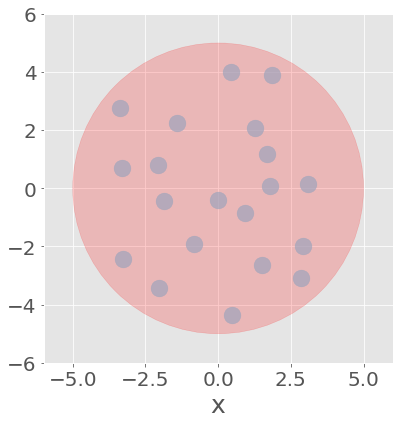

In [1095]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111, aspect='equal')
x = [-6, 2, 3, 4, 2, 3, 6]
y = [-6, 0, 0, 0, 1, 1, 6]
s = 0.0
points = ax.scatter(x,y,s=s,marker='s')
ax.axis([min(x)-1., max(x)+1., min(y)-1., max(y)+1.])
# retrieve the pixel information:
xy_pixels = ax.transData.transform(np.vstack([x,y]).T)
xpix, ypix = xy_pixels.T
# In matplotlib, 0,0 is the lower left corner, whereas it's usually the upper 
# right for most image software, so we'll flip the y-coords
width, height = fig.canvas.get_width_height()
ypix = height - ypix
# this assumes that your data-points are equally spaced
s1 = xpix[1]-xpix[0]
fig, ax= vis.nice_plot(X_start[:,0], X_start[:,1],scatter=True, scr_markerstyle= '.',
            scr_markersize= s1**2*.175**2, show_plot=False,alpha = .7,
            y_range = (-6,6), x_show_range=(-6,6), figure= fig, axis = ax)
circle1 = plt.Circle((0, 0), Radius, color='r', alpha = .2)
ax.add_patch(circle1)
fig

## Most likely number of crabs that remain alive {-} 

In [1050]:
Nexp = 300
Crabs_alive = []
M_largest = []
Day_10_survive = []
for i in range(Nexp):
    X_new, M_new, day10_survive = simulate(Ndays, X_start, M0)
    Crabs_alive.append(len(M_new))
    M_largest.append(np.max(M_new))
    Day_10_survive.append(day10_survive)
Crabs_alive = np.array(Crabs_alive)
M_largest = np.array(M_largest)
Day_10_survive = np.array(Day_10_survive)

Below the distribution of the number of survived crabs is shown.

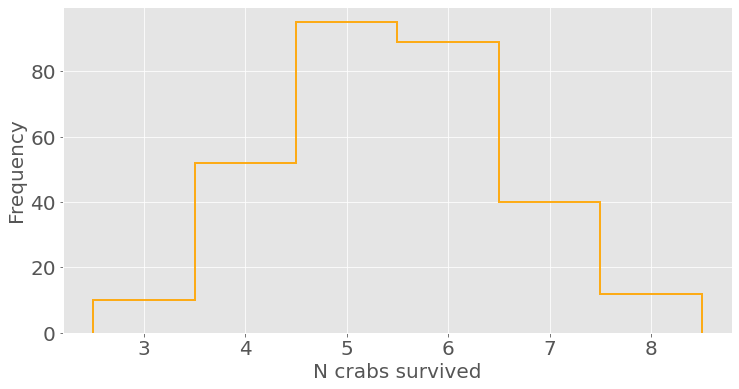

In [938]:
bins= np.arange(Crabs_alive.min()-.5, Crabs_alive.max()+.5)
fd = vis.nice_histogram(Crabs_alive, bins, xlabel = 'N crabs survived')
fd['fig']

The most likely number of crabs that remain alive is 5.

This figure shows the mass of the largest crab by the end of 200 days for 300 pseudo-experiments.

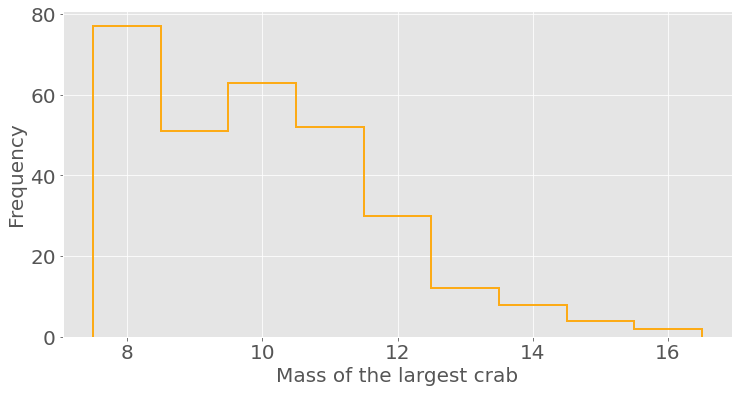

In [939]:
bins= np.arange(M_largest.min()-.5, M_largest.max()+.5)
fd = vis.nice_histogram(M_largest, bins, xlabel = 'Mass of the largest crab')
fd['fig']

## Problem 3d {-} 

In [863]:
#we have to slightly modify the functions

In [1052]:
X_start = np.loadtxt(url , skiprows = 0)
M0 = np.ones(len(X_start))

In [1053]:
Nexp = 300
Day_10_survive = []
for i in range(Nexp):
    X_new, M_new, day10_survive = simulate(Ndays, X_start, M0, count_survive=True)
    Day_10_survive.append(day10_survive)
Day_10_survive = np.array(Day_10_survive)

Here we can see the days until only 10 crabs survive. There is probably a bug in the code since 0 days seems unrealistic.

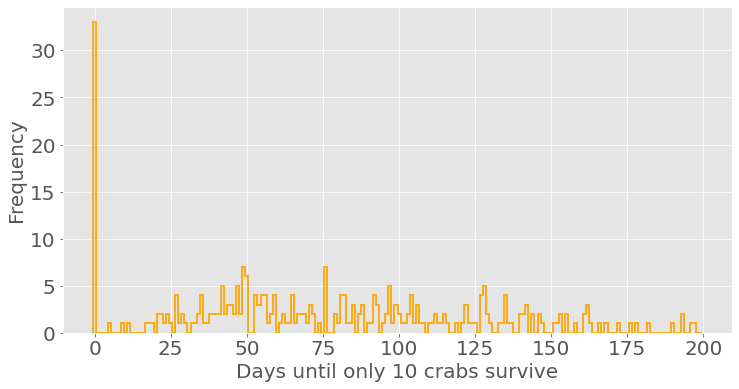

In [1054]:
bins= np.arange(Day_10_survive.min()-.5, Day_10_survive.max()+.5)
fd = vis.nice_histogram(Day_10_survive, bins, xlabel = 'Days until only 10 crabs survive')
fd['fig']

# Problem 4 {-} 

In [1064]:
Ndays = 500
Asold = 5
lam_lost = 23
lam = 23
mu_A = 240
sig_A = 10
Nhours = 10
Trading_time = []#np.empty(Ndays)
A = np.zeros((Ndays, Nhours))
#simulating is one choice, maybe better to look at the pdfs
for i in range(Ndays):
    A0 = 412
    for j in range(Nhours):
        A[i,j] = A0
        p_exch = stats.norm.pdf(A0, loc = mu_A, scale = sig_A)
        if p_exch>np.random.uniform():
            Trading_time.append(j)
            break
        A0 -= (stats.poisson.rvs(lam_lost)+Asold)
Trading_time = np.array(Trading_time)

In [1093]:
#bins = np.arange(-.5,Trading_time.max()+.5)#shift bins
#labels = ['8:00','9:00', '10:00', '11:00', '12:00', '13:00', 
#          '14:00', '15:00', '16:00', '17:00','18:00']
#fd = vis.nice_histogram(np.array(Trading_time), bins, 
                        #xlabel='Time [HH:MM]', figsize = (14,5))
#fd['ax'].set_xticklabels(labels)
#fd['ax'].set_xticks(np.arange(0,10))
#fd['fig']
#N pseudo-experiments were run, drawing random numbers from the poisson distribution to determine
#the amount of lost fish and trade with a probability described by the prior.

In [1065]:
#The probability for lossing N fish after t hours is given by:
def p_loose(N_lost, t): return stats.poisson.pmf(N_lost, t*lam)
def flikelihood_left(N_left, t): 
    N_sold = t*5
    N_lost = 412 - N_left - N_sold
    return p_loose(N_lost,t)
def fprior_exch(N_left):
    return stats.norm.pdf(N_left, 240, 10)
def fposterior(N_left, t):
    return flikelihood_left(N_left,t)*fprior_exch(N_left)

In [1066]:
hours = np.arange(10)
fish_arr = np.arange(0,412)
Posterior_landscape =[]
for i in hours:
    Posterior_landscape.append(fposterior(fish_arr, i))
Posterior_landscape = np.array(Posterior_landscape)

In [1069]:
#np.sum(Posterior_landscape.T, axis = 0)

This shows the posterior landscape of the exchange probability. The exchange takes most likely place at 14:00.

In [1073]:
#hh[Posterior_landscape.T==Posterior_landscape.T.max()]

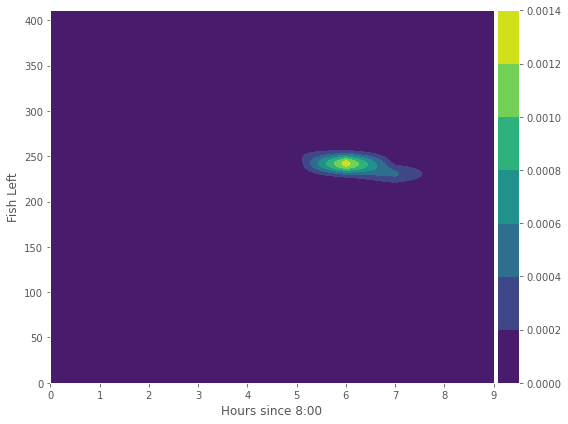

In [1068]:
hh, ff = np.meshgrid(hours, fish_arr)
fig, ax= plt.subplots(figsize = (8,6))
im = ax.contourf(hh, ff, Posterior_landscape.T)
ax.set_xlabel('Hours since 8:00')
ax.set_ylabel('Fish Left')
divider = make_axes_locatable(ax)
cax0 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax0)
fig.tight_layout()
fig.savefig('Figs/P4a_posterior.png', dpi = 80)

In [1076]:
#money0 = t0*6*5
#money1 = (T-t0)*10*3
#B_left = 120-
#money2 = B_left*4
#Money = money0 + money1 + money2

In [1078]:
#t0 = money/6/5
#t0 = T-money1/10/3
#B_sold = (T-t0)*3
#B_lost = 120 - B_left - B_sold

In [1079]:
def flikelihood_leftB(B_left, t0):
    B_lost = 120-B_left-(T-t0)*3
    return p_loose(B_lost, t1)

In [1080]:
xaxis = np.arange(100,300)
#vis.nice_plot(xaxis, , scatter=True)

# Problem 5 {-}

## Problem 5a {-} 

In [1081]:
D5 = np.array([[ 203.41 , -89.37 ], [ 203.435, -94.88 ],
    [ 203.46 , -101.25 ], [ 203.484, -106.52 ],
    [ 203.509, -108.66 ], [ 203.534, -114.25 ],
    [ 203.558, -114.3 ],
    [ 203.583, -117.66 ],
    [ 203.608, -122.45 ]])

Below we can see the cubic and linear interpolation of the data.

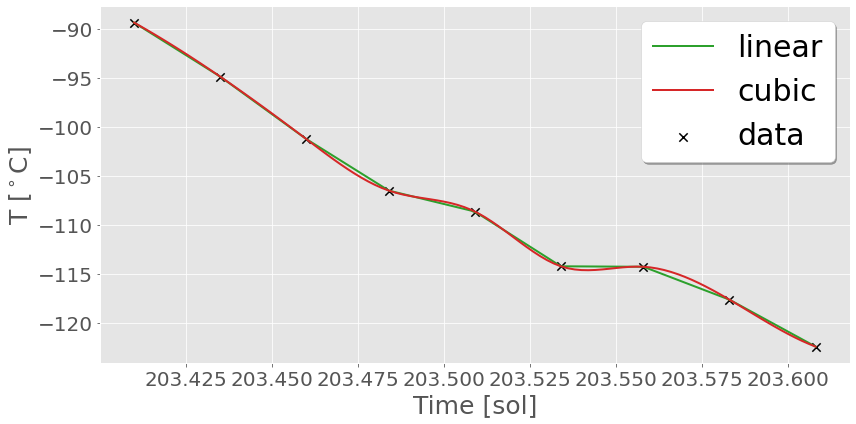

In [1082]:
day, temp = D5[:,0], D5[:,1]
x_lin = np.linspace(day.min(),day.max(),100)
fig, ax = vis.nice_plot(
    day, temp, figsize = (12,6), xlabel = 'sol', show_plot=False, 
    scatter = True, color = 'k', data_label='data', scr_markersize=70,
    scr_markerstyle='x')
f_lin = interpolate.interp1d(day, temp, 'linear')
f_cub = interpolate.interp1d(day, temp, 'cubic')
fig, ax = vis.nice_plot(x_lin, f_lin(x_lin), figsize = (12,8), xlabel = 'sol', 
                        show_plot=False, scatter = False, color = (0,2), data_label='linear',
                       axis = ax, figure = fig, linewidth=2)
fig, ax = vis.nice_plot(
    x_lin, f_cub(x_lin), figsize = (12,8),plot_legend=True,
    show_plot=False, scatter = False, color = (0,3), data_label='cubic',
    axis = ax, figure = fig,  xlabel = 'Time [sol]', ylabel =  'T '+r"$[^\circ \mathrm{C}]$",
    legend_fs=30, linewidth = 2)
fig

In [1084]:
sol_est = 203.570
cub_est = f_cub(sol_est)
lin_est = f_lin(sol_est)
#cub_est, lin_est

Temperature estimates from the splines:
- cubic spline: $-115.33\, ^\circ C$
- linear spline: $-115.91\, ^\circ C$

## Problem 5b {-} 

This figure shows a scatter plot of the splines in the region of interest.

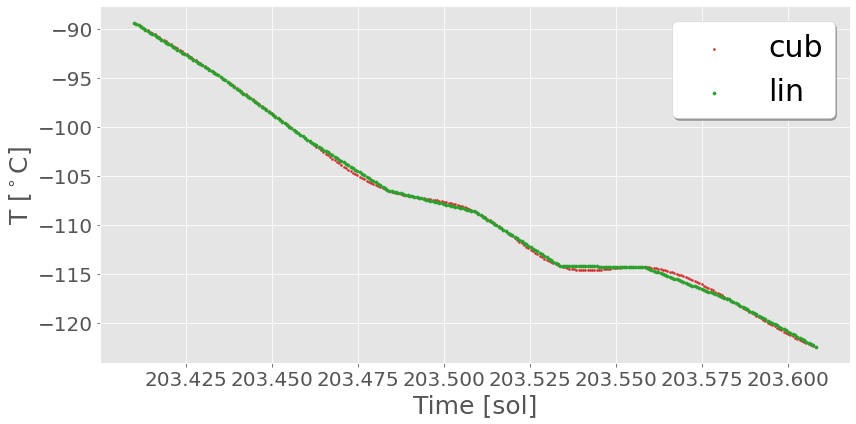

In [1085]:
day_min, day_max =  203.410, 203.608
scr_range = np.linspace(day_min, day_max, 300)
f_cub_der = f_cub._spline.derivative(nu=1)
fig, ax = vis.nice_plot(scr_range, f_cub(scr_range), figsize = (12,6),
                        show_plot=False, scatter = True, color = (0,3), data_label='cub',
                        scr_markersize=4)
fig, ax = vis.nice_plot(
    scr_range, f_lin(scr_range), 
    show_plot=False, scatter = True, color = (0,2), data_label='lin',
    scr_markersize=10, axis = ax, figure = fig,plot_legend=True,
    legend_fs=30, xlabel = 'Time [sol]', ylabel = 'T '+r"$[^\circ \mathrm{C}]$",)


fig

In [1087]:
cub_der = f_cub_der(scr_range)
mask_pos = cub_der.flatten()>0
pos_region = scr_range[mask_pos]
#pos_region.max(), pos_region.min()

We should look more closely at the region [203.56, 203.54], as the derivative of the spline in that region is 0.

## Problem 5b {-} 

In [1089]:
dT = 0.09 
dday = 0.0004
temp_change = dT/dday
#temp_change

All regions, where the derivative is below the red line are critical regions for the rover. According to the interpolation the electronics would need more robustness.

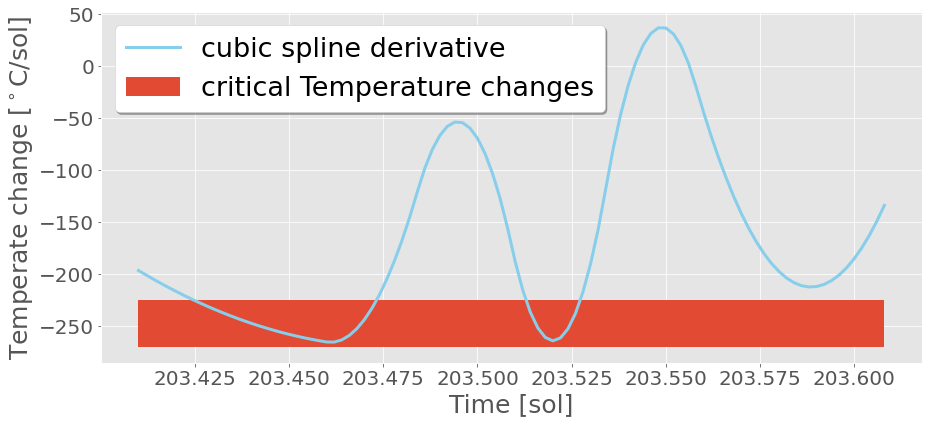

In [1090]:

fig, ax = vis.nice_plot(
    x_lin, f_cub_der(x_lin), legend_fs=30,
    show_plot=False, figsize = (13,6), data_label='cubic spline derivative',
    xlabel='Time [sol]', ylabel="Temperate change "+r"$[^\circ \mathrm{C}/\mathrm{sol}]$")
ax.fill_between(x_lin, -270, -temp_change, label = 'critical Temperature changes')
legend = ax.legend(fontsize = 27, shadow = True)
legend.get_frame().set_facecolor('white')
fig